hfd data wrangling

In [1]:
!pip install h5py

john imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np
import math
import h5py
import random
from scipy.signal import find_peaks, peak_widths
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix,  ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

john google drive (data)

In [3]:
# # mount the google drive - this is necessary to access supporting resources
# from google.colab import drive
# drive.mount("/content/drive")

john standardize (so those samples where it goes like _/- get flatted to ---)

In [4]:
def standardize_wave(signal):
    signal = np.asarray(signal)

    # If signal is too short to compute differences, return empty
    if len(signal) < 2:
        return np.array([])

    # Compute the discrete derivative
    diff_signal = np.diff(signal)

    # Z-score the derivative: (x - mean) / std
    mean_diff = np.mean(diff_signal)
    std_diff = np.std(diff_signal)

    # To avoid division by zero if the std is 0, handle gracefully:
    if std_diff == 0:
        # This would mean the signal differences are all the same (or all zero)
        # so we can just return a zero array of the same shape
        return np.zeros_like(diff_signal)

    standardized_diff = (diff_signal - mean_diff) / std_diff

    return standardized_diff

reads in waveforms to arrays in dataframe, standardizes them

In [5]:
num_of_code15_datasets = 3

lead_names = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF',
              'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# ----- PROCESS CODE15 DATASET -----
print("Processing Code15 dataset...")
code15_labels_path = "../data/Code15/code15_chagas_labels.csv"

code15_labels_df = pd.read_csv(code15_labels_path)
code15_records = []

# Open the Code15 HDF5 file
#code15_hdf5_path_seg = "../data/Code15/exams_part0.hdf5"
for i in range (num_of_code15_datasets):
    code15_hdf5_path = "../data/Code15/exams_part" + str(i) + ".hdf5"
    with h5py.File(code15_hdf5_path, "r") as f:
        # Load the exam ids
        exam_ids_hdf5 = f['exam_id'][:]
        # Build a mapping from exam_id to its index
        exam_id_to_index = {str(eid): idx for idx, eid in enumerate(exam_ids_hdf5)}
        
        # Access the tracings dataset
        tracings = f['tracings']
        
        # Process each exam_id from the CSV
        for _, row in code15_labels_df.iterrows():
            exam_id = str(row['exam_id'])
            chagas_val = row['chagas']
            
            # Ensure the exam_id exists in the HDF5 file
            if exam_id in exam_id_to_index:
                index = exam_id_to_index[exam_id]
                # Read only the required chunk for this exam_id
                ecg_data = tracings[index, :, :]
                
                # Create a record for the DataFrame
                record = {"exam_id": exam_id, "chagas": chagas_val, "source": "CODE15"}
                # For each lead, extract the corresponding signal and trim leading/trailing zeros
                for j, lead in enumerate(lead_names):
                    signal = ecg_data[:, j]
                    # Find indices of non-zero elements
                    nonzero_indices = np.nonzero(signal)[0]
                    if nonzero_indices.size > 0:
                        start = nonzero_indices[0]
                        end = nonzero_indices[-1] + 1
                        trimmed_signal = signal[start:end]
                    else:
                        trimmed_signal = signal
                    record[lead] = trimmed_signal
                
                code15_records.append(record)
        
        print(f"Processed {len(code15_records)} records from Code15 dataset")

# Create Code15 DataFrame
code15_df = pd.DataFrame(code15_records)
print(code15_df.shape)

# ----- PROCESS SAMI DATASET -----

print("\nProcessing SAMI dataset...")
sami_labels_path = "../data/sami/samitrop_chagas_labels.csv"
sami_hdf5_path = "../data/sami/sami_exams.hdf5"

# Load SAMI labels
sami_labels_df = pd.read_csv(sami_labels_path)

sami_records = []
# SAMI lead names (these are different from CODE15)
sami_lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Open SAMI HDF5 file and process data
with h5py.File(sami_hdf5_path, 'r') as hdf:
    # Access the tracings dataset
    tracings = hdf['tracings']
    
    # Process each row in the labels dataframe
    for idx, row in sami_labels_df.iterrows():
        # Get information from CSV
        exam_id = str(row['exam_id'])
        chagas_val = row['chagas']
        
        try:
            # Use the index position to access the corresponding tracing
            ecg_data = tracings[idx, :, :]
            
            # Create a record with exam_id and chagas label
            record = {"exam_id": f"SAMI_{exam_id}", "chagas": chagas_val, "source": "SAMI"}
            
            # Process each lead - converting SAMI lead names to our standard lead_names
            for j, sami_lead in enumerate(lead_names):
                # # Get the equivalent standard lead name
                # standard_lead = lead_names[sami_lead]
                
                signal = ecg_data[:, j]
                
                # Find indices of non-zero elements for trimming
                nonzero_indices = np.nonzero(signal)[0]
                if nonzero_indices.size > 0:
                    start = nonzero_indices[0]
                    end = nonzero_indices[-1] + 1
                    trimmed_signal = signal[start:end]
                else:
                    trimmed_signal = signal
                    
                record[sami_lead] = trimmed_signal
            
            sami_records.append(record)
            
        except IndexError:
            print(f"Error processing SAMI record at index {idx} with exam_id {exam_id}")
    
    print(f"Processed {len(sami_records)} records from SAMI dataset")

# Create SAMI DataFrame
sami_df = pd.DataFrame(sami_records)

# ----- COMBINE DATASETS -----
print("\nCombining datasets...")

# Ensure both dataframes have the same columns using our standard lead_names
df = pd.concat([code15_df, sami_df], ignore_index=True)

# Standardize each ECG signal array for each lead
for lead in lead_names:
    df[lead] = df[lead].apply(lambda signal: standardize_wave(signal))  

print(df.shape)

Processing Code15 dataset...
Processed 19939 records from Code15 dataset
Processed 39887 records from Code15 dataset
Processed 59841 records from Code15 dataset
(59841, 15)

Processing SAMI dataset...
Processed 815 records from SAMI dataset

Combining datasets...
(60656, 15)


average and standard deviations of both qrs distance approximation (i tried using neurokit2's ecg delineate to get it but it wasn't working as was really slow) and peak-to-peak distance

In [6]:
def average_qrs_distance(ecg, relative_height=0.3):
    ecg = np.asarray(ecg)

    # Find peaks. You can customize the parameters (like prominence or height) if needed.
    peaks, _ = find_peaks(ecg, height=2)

    if len(peaks) == 0:
        return np.nan

    # Compute widths of the detected peaks at the specified relative height.
    widths_results = peak_widths(ecg, peaks, rel_height=relative_height)
    widths = widths_results[0]  # the first element contains the widths

    return np.mean(widths)

def std_qrs_distance(ecg, relative_height=0.3):
    ecg = np.asarray(ecg)

    # Find peaks. You can customize the parameters (like prominence or height) if needed.
    peaks, _ = find_peaks(ecg, height=2)

    if len(peaks) == 0:
        return np.nan

    # Compute widths of the detected peaks at the specified relative height.
    widths_results = peak_widths(ecg, peaks, rel_height=relative_height)
    widths = widths_results[0]  # the first element contains the widths

    return np.std(widths)

def avg_peak_to_peak(signal, height=2, distance=40):
    # Detect peaks using the specified parameters.
    peak_indices, _ = find_peaks(signal, height=height, distance=distance)

    # If fewer than two peaks are found, return NaN.
    if len(peak_indices) < 2:
        return np.nan

    # Calculate the distances between successive peaks.
    peak_to_peak_distances = np.diff(peak_indices)

    # Return the average of these distances.
    return np.mean(peak_to_peak_distances)

def std_peak_to_peak(signal, height=2, distance=40):
    # Detect peaks using the specified parameters.
    peak_indices, _ = find_peaks(signal, height=height, distance=distance)

    # If fewer than two peaks are found, return NaN.
    if len(peak_indices) < 2:
        return np.nan

    # Calculate the distances between successive peaks.
    peak_to_peak_distances = np.diff(peak_indices)

    # Return the average of these distances.
    return np.std(peak_to_peak_distances)

these next few are all in separate cells so you can add a new feature without rerunning everything

avg qrs

In [7]:
for lead in lead_names:
    df[f"avg_qrs_{lead}"] = df[lead].apply(lambda wave: average_qrs_distance(wave))

std qrs

In [8]:
for lead in lead_names:
    df[f"std_qrs_{lead}"] = df[lead].apply(lambda wave: std_qrs_distance(wave))

avg p2p

In [9]:
for lead in lead_names:
    df[f"avg_p2p_{lead}"] = df[lead].apply(lambda signal: avg_peak_to_peak(signal))

std p2p

In [10]:
for lead in lead_names:
    df[f"std_p2p_{lead}"] = df[lead].apply(lambda signal: std_peak_to_peak(signal))

min value

In [11]:
for lead in lead_names:
    df[f'min_{lead}'] = df[lead].apply(lambda signal: np.min(signal) if len(signal) > 0 else np.nan)

std of signal

In [12]:
for lead in lead_names:
    df[f'std_{lead}'] = df[lead].apply(lambda signal: np.std(signal) if len(signal) > 0 else np.nan)

max value

In [13]:
for lead in lead_names:
    df[f'max_{lead}'] = df[lead].apply(lambda signal: np.max(signal) if len(signal) > 0 else np.nan)

drops the waveform data, exam_id, and NaN

In [14]:
df2 = df.drop(columns=lead_names + ["exam_id"])
df2 = df2.dropna() 

test train split 80/20

In [15]:
print(df.shape)  

X_train, X_test, y_train, y_test = train_test_split(df2.drop(['chagas', 'source'], axis=1), df2['chagas'], test_size=0.2, random_state=1989)
#X_train, X_test, y_train, y_test = train_test_split(df2.drop('chagas', axis=1), df2['chagas'], test_size=0.2, random_state=1989)

print(df.shape)  
print(X_train.shape)  
print(X_test.shape)  
print(y_train.shape)  
print(y_test.shape)  

(60656, 99)
(60656, 99)
(46855, 84)
(11714, 84)
(46855,)
(11714,)


john standard

In [16]:
# let's standardize the data
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)
# transform the training data and put it into a new dataframe
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# transform the testing data and put it into a new dataframe
# notice -- we do not fit on the test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

to try and help handle class imbalance

In [17]:
smote = SMOTE(random_state=1989)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

balanced random forest classifier also attempts to deal with class imbalance

In [23]:
# model_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=1989, criterion = 'gini', max_depth = 30, bootstrap = True)
# model_rf.fit(X_train_scaled, y_train)

model = BalancedRandomForestClassifier()

# Specify hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision')

# Fit to the data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
model_rf = grid_search.best_estimator_

the optimal parameters in question

In [24]:
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [25]:
feature_names = [col for col in df2.columns if col != 'chagas']

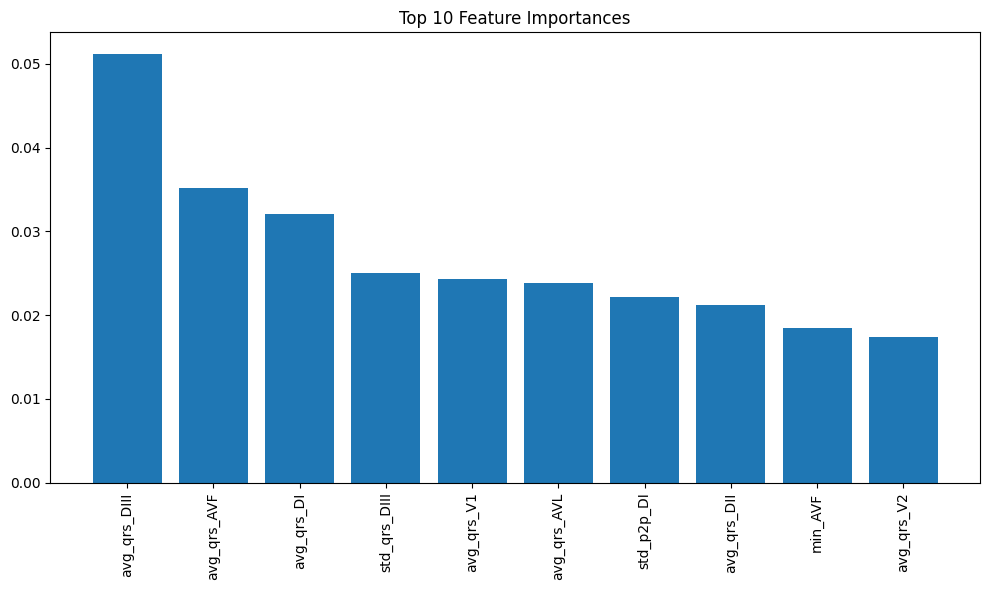

In [26]:
importances = model_rf.feature_importances_

# Sort the feature importances in descending order and select the top 10
indices = np.argsort(importances)[::-1][:10]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

checks that jawn

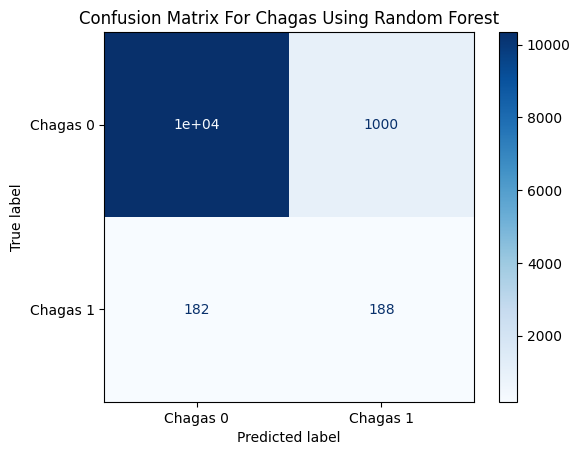

In [27]:
predictions = model_rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=[f'Chagas {i}' for i in range(2)])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix For Chagas Using Random Forest')
plt.show()

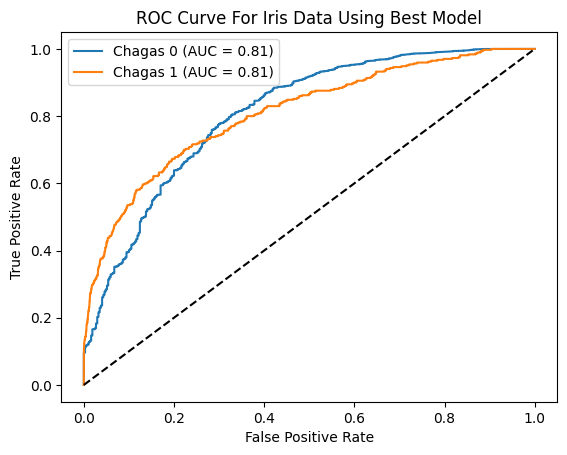

In [28]:
# let's plot the roc curve for each class
# we need to get the probabilities for each class
probs = model_rf.predict_proba(X_test_scaled)
fpr = dict()
tpr = dict()
roc_auc = {0:0, 1:0}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, probs[:, i], pos_label=i)
    # roc_auc expects binary values, so we need to convert the target to binary
    # we're using one vs. all, so we'll convert the target to 1 for the class we're interested in and 0 for the other classes
    y_test_i = np.array(y_test == i).astype(int)
    roc_auc[i] = roc_auc_score(y_test_i, probs[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Chagas {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Iris Data Using Best Model')
plt.legend()
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_adjusted)
print("\nClassification Report:")
print(report)

In [21]:
print(df.columns)
print(df['chagas'].sum()) 
print((df['chagas'] == False).sum())  


Index(['exam_id', 'chagas', 'source', 'DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF',
       'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'avg_qrs_DI', 'avg_qrs_DII',
       'avg_qrs_DIII', 'avg_qrs_AVR', 'avg_qrs_AVL', 'avg_qrs_AVF',
       'avg_qrs_V1', 'avg_qrs_V2', 'avg_qrs_V3', 'avg_qrs_V4', 'avg_qrs_V5',
       'avg_qrs_V6', 'std_qrs_DI', 'std_qrs_DII', 'std_qrs_DIII',
       'std_qrs_AVR', 'std_qrs_AVL', 'std_qrs_AVF', 'std_qrs_V1', 'std_qrs_V2',
       'std_qrs_V3', 'std_qrs_V4', 'std_qrs_V5', 'std_qrs_V6', 'avg_p2p_DI',
       'avg_p2p_DII', 'avg_p2p_DIII', 'avg_p2p_AVR', 'avg_p2p_AVL',
       'avg_p2p_AVF', 'avg_p2p_V1', 'avg_p2p_V2', 'avg_p2p_V3', 'avg_p2p_V4',
       'avg_p2p_V5', 'avg_p2p_V6', 'std_p2p_DI', 'std_p2p_DII', 'std_p2p_DIII',
       'std_p2p_AVR', 'std_p2p_AVL', 'std_p2p_AVF', 'std_p2p_V1', 'std_p2p_V2',
       'std_p2p_V3', 'std_p2p_V4', 'std_p2p_V5', 'std_p2p_V6', 'min_DI',
       'min_DII', 'min_DIII', 'min_AVR', 'min_AVL', 'min_AVF', 'min_V1',
       'min_V2', 'min_V3', '